[Analysis](#analysis_header)

In [2]:
%load_ext autoreload
%autoreload 2

import bz2
import json
import re
import random
import sys
import os
import bz2
import time
import pandas as pd
import numpy as np
from functools import partial
import seaborn as sns
from helpers import *

import bz2
import json
import csv

import seaborn as sns
from helpers import PERSONALITY_ATTRS
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
plt.style.use('ggplot')
sns.set_style('white')

from ipywidgets import widgets, interactive
from io import StringIO
import math

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# PREPROCESSING

In [3]:
PATTERN_INPUT = "../quotebank/quotes-{}.json.bz2"

### Get significant quote count for each speaker

In [4]:
with open("data/local_only/signi-quote-count-combined_1636658426963.json", "r") as f:
    sorted_combined_signi_dict = json.load(f)

### Get the wikidata

We used the https://query.wikidata.org/ website to get the relevant wikidata. The SPARQL query is in the following cell.
<br>
The parquet file does not contain necessary data - manner of death, cause of death

In [ ]:
SELECT DISTINCT ?item ?itemLabel 
          ?genderLabel ?citizenshipLabel ?languageLabel ?religionLabel ?ethnicLabel ?degreeLabel ?dateOfBirth ?placeOfBirthLabel ?occupationLabel
WHERE {
  SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE]". }
  {
    {
      ?item p:P1196 ?statement0.
      ?statement0 (ps:P1196) wd:Q10737.
    }
    UNION
    {
      ?item p:P509 ?statement1.
      ?statement1 (ps:P509) wd:Q175111.
    }
    
    OPTIONAL { ?item wdt:P21 ?gender. }
    OPTIONAL { ?item wdt:P27 ?citizenship. }
    OPTIONAL { ?item wdt:P103 ?language. }
    OPTIONAL { ?item wdt:P140 ?religion. }
    OPTIONAL { ?item wdt:P172 ?ethnic. }
    OPTIONAL { ?item wdt:P512 ?degree. }
    OPTIONAL { ?item wdt:P106 ?occupation. }
    OPTIONAL { ?item wdt:P569 ?dateOfBirth. }
  }
}

Merge duplicate objects representing a single speaker but with differing fields.
<br>
Example: Arnold Schwarzenegger has both Austrian and American nationalities, and would appear twice, once with Austrian, and once with American nationality.

In [5]:
with open("data/local_only/suicide_query_and_hangings_and_after_2015.json", "r", encoding='utf-8') as f:
    suicide_squad = json.load(f)

In [6]:
suicide_squad_merged = merge_wikidata_entries(
    suicide_squad,
    ['itemLabel', 'genderLabel', 'citizenshipLabel', 'religionLabel', 'degreeLabel', 'dateOfBirth', 'languageLabel']
)

In [7]:
write_json_to_file('data/local_only/suicide_list_merged', suicide_squad_merged)

'data/local_only/suicide_list_merged_1639686588316.json'

### Get the 100 most quoted suicide victims

In [8]:
with open("data/local_only/suicide_list_merged_1638730998799.json", "r", encoding='utf-8') as f:
    suicide_merged = json.load(f)

In [9]:
suicide_df = pd.DataFrame.from_dict(suicide_merged, orient='index')

In [10]:
suicide_df.head()

,item,itemLabel,genderLabel,citizenshipLabel,languageLabel,dateOfBirth,placeOfBirthLabel,religionLabel,ethnicLabel,memberOfParty,memberOfPartyLabel,degreeLabel
Q579188,Q579188,Arthur Cravan,male,"[United Kingdom of Great Britain and Ireland, ...",French,1887-05-22T00:00:00Z,Lausanne,NaN,NaN,NaN,NaN,NaN
Q508141,Q508141,Andrew Urdiales,male,United States of America,NaN,1964-06-04T00:00:00Z,Chicago,NaN,NaN,NaN,NaN,NaN
Q623582,Q623582,Ara Gallant,male,United States of America,NaN,1932-01-01T00:00:00Z,The Bronx,NaN,NaN,NaN,NaN,NaN
Q701279,Q701279,Du Wenxiu,male,Qing dynasty,NaN,1823-01-01T00:00:00Z,NaN,Islam,NaN,NaN,NaN,NaN
Q708682,Q708682,Dimitris Liantinis,male,Greece,NaN,1942-07-23T00:00:00Z,Taygetus,NaN,Greeks,NaN,NaN,NaN


Using the number of quotes for each speaker, and the list of suicide victims, we can compile a list of 100 most quoted suicide victims.

In [11]:
suicide100 = []
CAP_TARGET = 100

for v in sorted_combined_signi_dict:
    row = suicide_merged.get(v, None)
    
    # Could not find person in the suicide dictionary
    if row is None:
        continue
        
    # Append to list
    suicide100.append(row)
    
    # Check if lists are at full capacity
    if len(suicide100) == CAP_TARGET:
        break

In [12]:
sorted_combined_signi_dict.get('Q15521785', -1)

1

Display the list of suicide victims.

In [13]:
BOLD = '\033[1m'
END = '\033[0m'
print(BOLD + f'{"":3} {"People that commited suicide":62}' + END)
print(BOLD + f'{"":3} {"Name":30} {"ID":10} {"Number of quotes":20}' + END)

for index in range(10):
    row = suicide100[index]
    
    v = row['itemLabel']
    q = row['item']
    c = str(sorted_combined_signi_dict.get(q, -1))
    
    print(f"{index + 1:3} {v:30} {q:10} {c:20}")
    
    index += 1
    if index % 10 == 0:
        print()

    People that commited suicide                                  
    Name                           ID         Number of quotes    
  1 Anthony Bourdain               Q426582    2689                
  2 Caroline Flack                 Q2939998   1431                
  3 David Hamilton                 Q127677    969                 
  4 John McAfee                    Q45864     964                 
  5 Chris Cornell                  Q270935    780                 
  6 Ashwani Kumar                  Q13426864  735                 
  7 Chester Bennington             Q19198     502                 
  8 Abubakar Shekau                Q2822101   329                 
  9 Aaron Hernandez                Q302091    308                 
 10 Jeffrey Epstein                Q2904131   268                 



### Get the quotes

For the suicide victims in the previously compiled lists, we now fetch the quotes from the quote files.

In [14]:
suicide_set = set()
for v in suicide100:
    suicide_set.add(v['item'])

# Define partial function check_if_dem_or_rep_quote using function check_if_party_member_quote
check_if_suicide_quote = partial(check_if_speaker_quote, speakers=suicide_set)

Create files for every year, each file contains a dictionary where the key is the QID of the speaker, and the value is the list of significant quotes attributed to the speaker.
<br><br>
<font color='red'>WARNING: LONG EXECUTION!</font>

In [ ]:
years = [2015, 2016, 2017, 2018, 2019, 2020]

output_list = []

for year in years:
    path_to_input = PATTERN_INPUT.format(year)
    
    # Process quote file
    output_name = process_compressed_json_file(path_to_input, 'data/suicide-quotes', year, check_if_suicide_quote)
    
    output_list.append(output_name)

print('\n\nOutput file names:')
for file_name in output_list:
    print(file_name)

### Combine the quotes

In [15]:
suicide_quote_files = [
    "data/local_only/suicide-quotes-2015_1638733582656.json",
    "data/local_only/suicide-quotes-2016_1638734492424.json",
    "data/local_only/suicide-quotes-2017_1638736277871.json",
    "data/local_only/suicide-quotes-2018_1638738456963.json",
    "data/local_only/suicide-quotes-2019_1638739764361.json",
    "data/local_only/suicide-quotes-2020_1638740031014.json"
]

suicide_quotes_combined = combine_quotes_files_2nd_format(suicide100, suicide_quote_files)

In [16]:
write_json_to_file('data/local_only/suicide-quotes-combined', suicide_quotes_combined)

'data/local_only/suicide-quotes-combined_1639686596339.json'

### Filter the quotes

Some of the quotes in the database do not represent actual quotes, but instead contain junk like html tags, source code, or text from the webpage where the source article was published.
<br>
We filter these quotes out so our dataset is not polluted by junk data. We have found a few filters which detect most of the junk data, while maintaining a low false positive rate:
<ul>
    <li>quotes which contains very long 'words' - more than 50 characters</li>
    <li>quotes which contain URLs - these usually contain other junk characters</li>
    <li>quotes which contains JSON-like key-value pairs</li>
    <li>quotes which contain a lot of special characters (more than 10% of total characters)</li>
</ul>

In [17]:
suicide_quotes_filtered = suicide_quotes_combined.copy()

In [18]:
suicide_quotes_filtered, dirty_quotes = filter_quotes_2nd_format(suicide_quotes_filtered)

Show some filtered quotes:

In [19]:
for entry in dirty_quotes[0:5]:
    print(entry['quotation'], end='\n\n')

Reply # 3 on: Yesterday at 06:50:41 PM

(It is) `Humble,

Reply # 2 on: May 19, 2015, 02:20:35 pm

Blockchain has the power to give artists and musicians the ownership of their own creation. The upcoming @BeatzCoin IEO on https://t.co/Miqj1EuSEb from September 30 will power the VibraVid platform to liberate countless artists & reward them for their work.

SEC says as long as we follow AML and KYC procedures the http://McAfeedex.com exchange is OK. But we don't follow either and why should we even if we could? We are just a window into the blockchain where people trade. This is for the people, not the Government. F * ck them.



### Concatenate the quotes

In [20]:
suicide_quotes_concat = suicide_quotes_filtered.copy()

In [21]:
suicide_quotes_concat = concatenate_quotes_2nd_format(suicide_quotes_concat)

In [22]:
index = 1
for key in suicide_quotes_concat.keys():
    x = suicide_quotes_concat[key]
    length = len(x['quotations'])
    
    if length < 5000:
        print(f'#{index:3} {key:10} : {length:10}')
    index += 1

# 62 Q58039238  :       4159
# 64 Q34645926  :       3326
# 69 Q42532791  :       4228
# 70 Q971772    :       4315
# 71 Q22343563  :       4888
# 72 Q27884463  :       4184
# 73 Q16142589  :       4133
# 74 Q7817498   :       3017
# 75 Q19828026  :       3019
# 76 Q7492996   :       4691
# 77 Q55767129  :       3125
# 78 Q7615615   :       2716
# 79 Q29051574  :       3781
# 80 Q16839079  :       3062
# 81 Q25999399  :       2058
# 82 Q10899897  :       3503
# 83 Q15945364  :       4058
# 84 Q7929198   :       4382
# 85 Q28838314  :       3864
# 86 Q17595042  :       2989
# 87 Q2555308   :       2814
# 88 Q1270169   :       1821
# 89 Q19633964  :       2845
# 90 Q21064429  :       3754
# 91 Q6917853   :       2476
# 92 Q472623    :       2940
# 93 Q21423818  :       3210
# 94 Q5887763   :       2109
# 95 Q6447875   :       4466
# 96 Q319751    :       3037
# 97 Q51881756  :       2138
# 98 Q7294771   :       2561
# 99 Q4714168   :       2763
#100 Q983856    :       3601


In [23]:
CUTOFF = 60

suicide_quotes_final = dict()
for index, key in enumerate(suicide_quotes_concat):
    if index == CUTOFF:
        break
    
    suicide_quotes_final[key] = suicide_quotes_concat[key]

In [27]:
write_json_to_file('data/local_only/suicide-quotes-top-60', suicide_quotes_final)

'data/local_only/suicide-quotes-top-60_1639686626612.json'

### LIWC output

In [28]:
sui_liwc = pd.read_csv('data/local_only/sui_output_1.csv')

In [29]:
# Visualise a random sample
sui_liwc.sample()

,Source (A),Source (B),WC,WPS,Sixltr,Dic,Pronoun,I,We,Self,...,Comma,Colon,SemiC,QMark,Exclam,Dash,Quote,Apostro,Parenth,OtherP
8,Q302091,"Shay, you have always been my soul-mate and i...",989,12.84,9.81,79.68,20.22,10.82,0.4,11.22,...,3.34,0.0,0.0,0.2,3.34,2.63,0.0,3.64,1.82,4.75


In [30]:
ctrl_liwc = pd.read_csv('data/top_1000_output_1.csv')

In [31]:
ctrl_liwc.sample()

,Source (A),Source (B),WC,WPS,Sixltr,Dic,Pronoun,I,We,Self,...,Comma,Colon,SemiC,QMark,Exclam,Dash,Quote,Apostro,Parenth,OtherP
578,Q5207523,I'm happy. I'm effervescent. The story on tha...,991,12.71,11.81,82.14,16.35,4.34,2.72,7.06,...,3.33,0.0,0.0,0.3,0.0,0.3,0.0,4.34,0.0,0.81


### Personality

In [32]:
sui_personality = predict_personality(sui_liwc)

In [33]:
ctrl_personality = predict_personality(ctrl_liwc)

### Wikidata

In [34]:
with open('data/local_only/suicide-quotes-top-60_1638815474527.json', 'r', encoding='utf-8') as f:
    sui_wikidata = json.load(f)

In [35]:
with open('data/local_only/top-1000-quotes-concatenated_1638964313725.json', 'r', encoding='utf-8') as f:
    ctrl_wikidata = json.load(f)

### Merge LIWC and Wikidata

In [36]:
df1 = pd.concat([sui_liwc, sui_personality], axis=1)
sui_wikidata_pd = pd.DataFrame(sui_wikidata.values())

sui_df = df1.merge(sui_wikidata_pd, left_on='Source (A)', right_on='item', how='left')
sui_df.sample()

,Source (A),Source (B),WC,WPS,Sixltr,Dic,Pronoun,I,We,Self,...,genderLabel,citizenshipLabel,languageLabel,religionLabel,ethnicLabel,dateOfBirth,placeOfBirthLabel,quotations,memberOfParty,memberOfPartyLabel
29,Q234471,"In August 2015, at the Democratic Party conve...",910,14.44,17.58,75.16,11.21,4.29,0.99,5.27,...,female,"[Canada, United States of America]",NaN,atheism,NaN,1948-10-17T00:00:00Z,Yellowknife,"In August 2015, at the Democratic Party conve...",http://www.wikidata.org/entity/Q29552,Democratic Party


In [37]:
df1 = pd.concat([ctrl_liwc, ctrl_personality], axis=1)
ctrl_wikidata_pd = pd.DataFrame(ctrl_wikidata.values())

ctrl_df = df1.merge(ctrl_wikidata_pd, left_on='Source (A)', right_on='item', how='left')
ctrl_df.sample()

,Source (A),Source (B),WC,WPS,Sixltr,Dic,Pronoun,I,We,Self,...,item,itemLabel,genderLabel,citizenshipLabel,religionLabel,dateOfBirth,quotations,languageLabel,ethnicLabel,degreeLabel
719,Q6103950,"Well, look, we're going to have to do a lot. ...",861,19.57,23.11,71.66,8.48,1.74,3.37,5.11,...,Q6103950,J.B. Pritzker,male,United States of America,NaN,1965-01-19T00:00:00Z,"Well, look, we're going to have to do a lot. ...",NaN,NaN,NaN


### Merge into one dataframe for side-by-side comparison

In [38]:
sui_df_copy = sui_df.copy()
sui_df_copy['suicide'] = "Yes"
print(sui_df_copy.shape[0])

ctrl_df_copy = ctrl_df.copy()
ctrl_df_copy['suicide'] = "No"
# ctrl_df_copy = ctrl_df_copy.head(60)
print(ctrl_df_copy.shape[0])

60
1000


In [39]:
combdf = pd.concat([sui_df_copy, ctrl_df_copy]).reset_index()

<a id='analysis_header'></a>
# ANALYSIS

In [43]:
three_people_df = sui_df.copy()
three_people_df['speaker'] = three_people_df['itemLabel']
three_people_df = three_people_df[three_people_df['item'].isin(['Q426582', 'Q45864', 'Q505476'])].set_index('speaker')

three_people_df = three_people_df[PERSONALITY_ATTRS]

means = ctrl_df[PERSONALITY_ATTRS].mean()
stds = ctrl_df[PERSONALITY_ATTRS].std()
three_people_df = (three_people_df - means) / stds

<AxesSubplot:title={'center':'Normalized personality factors'}, ylabel='speaker'>

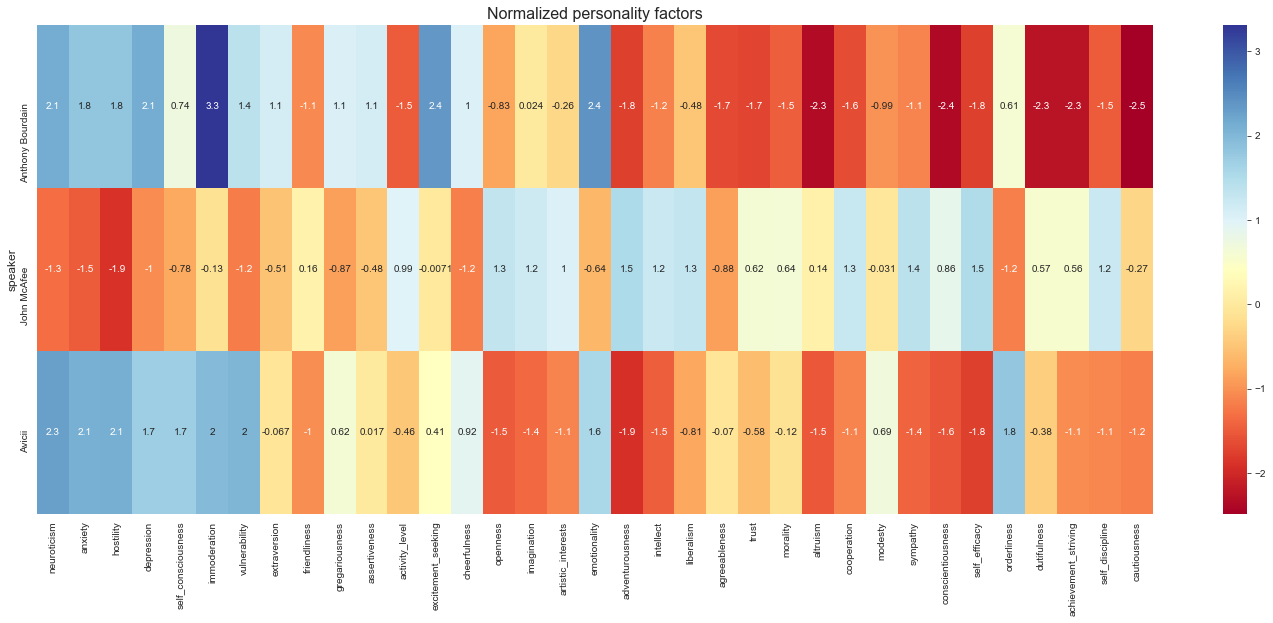

In [44]:
fig, ax = plt.subplots(figsize=(25, 9))
ax.set_title('Normalized personality factors', fontsize='16')
sns.heatmap(three_people_df, ax=ax, annot=True, cmap='RdYlBu')

In [49]:
print(PERSONALITY_ATTRS)

['neuroticism', 'anxiety', 'hostility', 'depression', 'self_consciousness', 'immoderation', 'vulnerability', 'extraversion', 'friendliness', 'gregariousness', 'assertiveness', 'activity_level', 'excitement_seeking', 'cheerfulness', 'openness', 'imagination', 'artistic_interests', 'emotionality', 'adventurousness', 'intellect', 'liberalism', 'agreeableness', 'trust', 'morality', 'altruism', 'cooperation', 'modesty', 'sympathy', 'conscientiousness', 'self_efficacy', 'orderliness', 'dutifulness', 'achievement_striving', 'self_discipline', 'cautiousness']


In [48]:
print(sorted_personality_attrs)

None


In [56]:
# Makesorted_personality_attrslect dropdown to select the Personality traits
sorted_personality_attrs = PERSONALITY_ATTRS.copy()
sorted_personality_attrs.sort()
personality_traits_multiselect = widgets.SelectMultiple(
    options=sorted_personality_attrs,
    value=['neuroticism', 'anxiety', 'depression', 'vulnerability', 'cheerfulness', 'emotionality'],
    description='Personality traits:',
)

def plot_histograms_for_traits(personality_traits):
    # Figure out the number of rows and columns of the subplots
    root = math.ceil(math.sqrt(len(personality_traits)))
    columns = max(1, root)
    rows = max(1, math.ceil(len(personality_traits) / columns))

    # Figure setup
    fig, axs = plt.subplots(rows, columns, figsize=(18.5, 8), squeeze=False)
    fig.tight_layout(pad=3.0)

    # Fill the subplots with histograms
    for i in range(rows):
        for j in range(columns):
            index = i * columns + j
            if (index >= len(personality_traits)):
                continue
            
            attr = personality_traits[index]
            sns.histplot(combdf, x=attr, hue='suicide', element="step", stat="density", common_norm=False, ax=axs[i][j])

In [57]:
interactive(plot_histograms_for_traits, personality_traits=personality_traits_multiselect)

interactive(children=(SelectMultiple(description='Personality traits:', index=(26, 5, 12, 34, 9, 14), options=…